## LifeLong Machine Learning

### 助教的投影片連結
[投影片](https://docs.google.com/presentation/d/13JmcOZ9i_m5xJbRBKNMAKE1fIzGhyaeLck3frY0B2xY/edit?usp=sharing)

### 定義
老師的影片有詳細說明定義 這裡不細提 詳細可以參考 [lifelong learning](https://youtu.be/7qT5P9KJnWo) 


### 方法
在2019年底，有人提出了一個大匯整將lifelong learning 的方法，從2016- 2019 年初 的模型做了歸類，大致上可以分成三種大方法
* Replay-based methods
* Regularization-based methods
* Parameter isolation methods

<img src="https://i.ibb.co/VDFJkWG/2019-12-29-17-25.png" width="100%">

在這次的作業之中，我們要走過一次regularization-based methods 裡面的 prior-focused的兩種方法 分別是 EWC 和 MAS 這兩種方法

圖片出處 [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf)

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com





In [ ]:
%%capture
# !pip3 install torch torchvision

# Import Libraries

In [ ]:
!pip install torch==1.7.0

     |████████████████████████████████| 776.7 MB 3.1 kB/s 
     |████████████████████████████████| 829 kB 45.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=c2e468be1a1efbb129af9508e52ac60a039f0592aabb03cd87a13f65d6589444
  Stored in directory: /home/jovyan/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install torchvision==0.8.1

     |████████████████████████████████| 12.7 MB 8.6 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
%%capture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

import numpy as np
import os
import random
from copy import deepcopy
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 模型

 >因為本次作業強調的是lifelong learning 的訓練方法，並非疊模型，所以今天我們所舉的例子，都會使用同一個模型來做訓練只是應用上不同lifelong learning的訓練方法， 在這次的作業的例子內 我們使用的是 一個 六層的 fully-connected layer 的 模型 加上 relu的 activation function.

## Basic Model

In [3]:
class Model(nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 3*32*32)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = self.relu(x)
    x = self.fc6(x)
    return x


以下我們將依序介紹這兩種方法 EWC 跟 MAS 

## EWC

### Elastic Weight Consolidation

#### 概念
老師在影片中已經把核心概念介紹給大家，那在這邊我想大家都非常了解了這個方法的概念，我們就直接進入主題

今天我們的任務 是在學習連續的兩個 task task A 跟 task B:

在 EWC 作法下 他的 loss function 會被定義如下
 $$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_{i} - \theta_{A,i}^{*})^2  $$

先解釋這個 loss function 裡的變數，$\mathcal{L}_B$ 是指 task B 的 loss, 會等於 正常的loss function $\mathcal{L}(\theta)$ (如果 是 classification 的問題,就是 cross entropy 的 loss function) 加上一個正則項 (regularization term) 

這個正則項的由兩個部份組成，第一個是 $F_i$ 也是這個方法的核心, 第二個部份是 $(\theta_{i} - \theta_{A,i}^{*})^2$  ,  $\theta_{A,i}^{*}$ 代表的是 訓練完task A 存下來模型第 i 個參數的值, $\theta_i$ 代表的是目前模型第i個參數的值，注意一點是模型的架構在這種 regularization based 的方法上，都是固定ㄉ，目前模型跟 task A 存下來的模型 架構都一樣只是值不一樣。底下我將說明這個 $F_i$ 是怎麼實做出來

在老師的影片中，老師是以只有兩個參數的模型舉例子，那假設我今天模型就是一個 neural network(參數不只兩個) 該怎麼辦呢？   

$F_i$ 對應到老師的影片敘述是指第i個參數的守衛，假設這個參數對 task A 很重要，那這個 $F_i$ 的值就會很大，這個參數盡量不能被更動...

實際上這個參數的算法 即是 如下的式子

$$ F = [ \nabla \log(p(y_n | x_n, \theta_{A}^{*}) \nabla \log(p(y_n | x_n, \theta_{A}^{*})^T ] $$ 

$F$ 之中 只以對角線的值去近似各個參數的 $F_i$ 值

$p(y_n | x_n, \theta_{A}^{*})$ 指的就是模型在給定之前 task 的 data $x_n$ 以及 給定 訓練完 task A 存下來的模型參數 $\theta_A^*$ 得到 $y_n$($x_n$ 對應的 label ) 的 posterior probability.
那統整一下作法就是 再對這個 $p(y_n | x_n, \theta_{A}^{*})$ 取 log 再取 gradient 並且平方 ( parameter.grad )^2.

每一個參數我都可以使用 pytorch 的 backward 之後再取 gradient 的性質算出各自的 $F_i$.

有關這個 $F$ 其實博大精深，是來自於 fisher information matrix. 底下我放上有關這個lifelong learning 在 fisher information matrix 上是怎麼簡單的近似到這一項，簡單的推導來自 [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf) 第2.4.1 小節 與 2.4 節

For You Information: [Elastic Weight Consolidation](https://arxiv.org/pdf/1612.00796.pdf)




In [4]:

class EWC(object):
  """
    @article{kirkpatrick2017overcoming,
        title={Overcoming catastrophic forgetting in neural networks},
        author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
        journal={Proceedings of the national academy of sciences},
        year={2017},
        url={https://arxiv.org/abs/1612.00796}
    }
  """
  def __init__(self, model: nn.Module, dataloaders: list, device):
    
    self.model = model
    self.dataloaders = dataloaders
    self.device = device
    
    self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} #抓出模型的所有參數
    self._means = {} # 初始化 平均參數
    self._precision_matrices = self._calculate_importance() # 產生 EWC 的 Fisher (F) 矩陣 
    
    for n, p in self.params.items():
      self._means[n] = p.clone().detach() # 算出每個參數的平均 （用之前任務的資料去算平均）
  
  def _calculate_importance(self):
    precision_matrices = {}
    for n, p in self.params.items(): # 初始化 Fisher (F) 的矩陣（都補零）
      precision_matrices[n] = p.clone().detach().fill_(0)

    self.model.eval()
    dataloader_num=len(self.dataloaders)
    number_data = sum([len(loader) for loader in self.dataloaders])
    for dataloader in self.dataloaders:
      for data in dataloader:
        self.model.zero_grad()
        input = data[0].to(self.device)
        output = self.model(input).view(1, -1)
        label = output.max(1)[1].view(-1)
        
        ############################################################################
        #####                      產生 EWC 的 Fisher(F) 矩陣                    #####
        ############################################################################    
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)             
        loss.backward()                                                    
                                                                           
        for n, p in self.model.named_parameters():                         
            precision_matrices[n].data += p.grad.data ** 2 / number_data   
                                                                   
    precision_matrices = {n: p for n, p in precision_matrices.items()}
    return precision_matrices

  def penalty(self, model: nn.Module):
    loss = 0
    for n, p in model.named_parameters():
      _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
      loss += _loss.sum()
    return loss


## MAS

### Memory Aware Synapses
概念:
老師的影片中，將它歸類到和 EWC 一樣的方法，只是算這個 important weight 的方式不太一樣.底下我將說明這個方法該怎麼實做

MAS:
在 MAS 內，學習一個連續的 tasks, task A, 和 task B, 他的 loss function 定義如下:

$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} \Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

和 ewc不同的是 式子中的 $F_i$ 被取代成 $\Omega_i$ , $\Omega_i$ 來自於以下的式子：

$$\Omega_i = || \frac{\partial \ell_2^2(M(x_k; \theta))}{\partial \theta_i} || $$ 

$x_k$ 是 來自於 前面 task 的 sample data。 式子上的作法就是對最後模型的 output vector (最後一層)做 l2 norm 後取平方 再對各自的weight微分(取gradient) 並且取 該 gradient 的絕對值，在該paper 中其實也可以對各個層的 output vector 做 l2 norm ( local 版本)，這邊只實做 global 的版本。


For Your Information: 
[Memory Aware Synapses](https://arxiv.org/pdf/1711.09601.pdf)
 






In [5]:

class MAS(object):
    """
    @article{aljundi2017memory,
      title={Memory Aware Synapses: Learning what (not) to forget},
      author={Aljundi, Rahaf and Babiloni, Francesca and Elhoseiny, Mohamed and Rohrbach, Marcus and Tuytelaars, Tinne},
      booktitle={ECCV},
      year={2018},
      url={https://eccv2018.org/openaccess/content_ECCV_2018/papers/Rahaf_Aljundi_Memory_Aware_Synapses_ECCV_2018_paper.pdf}
    }
    """
    def __init__(self, model: nn.Module, dataloaders: list, device):
        self.model = model 
        self.dataloaders = dataloaders
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} #抓出模型的所有參數
        self._means = {} # 初始化 平均參數
        self.device = device
        self._precision_matrices = self.calculate_importance() # 產生 MAS 的 Omega(Ω) 矩陣
    
        for n, p in self.params.items():
            self._means[n] = p.clone().detach()
    
    def calculate_importance(self):
        print('Computing MAS')

        precision_matrices = {}
        for n, p in self.params.items():
            precision_matrices[n] = p.clone().detach().fill_(0) # 初始化 Omega(Ω) 矩陣（都補零）

        self.model.eval()
        dataloader_num = len(self.dataloaders)
        num_data = sum([len(loader) for loader in self.dataloaders])
        for dataloader in self.dataloaders:
            for data in dataloader:
                self.model.zero_grad()
                output = self.model(data[0].to(self.device))

                #######################################################################################
                #####  產生 MAS 的 Omega(Ω) 矩陣 ( 對 output 向量 算他的 l2 norm 的平方) 再取 gradient  ####
                #######################################################################################
                output.pow_(2)                                                   
                loss = torch.sum(output,dim=1)                                   
                loss = loss.mean()                                               
                loss.backward()                                                  
                                          
                for n, p in self.model.named_parameters():                      
                    precision_matrices[n].data += p.grad.abs() / num_data ## difference with EWC      

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

# 資料

## 資料預處理
- 轉換 MNIST  ($1*28*28$) 到 ($3*32*32$)
- 轉換 USPS   ($1*16*16$) 到 ($3*32*32$)
- 正規化 圖片

In [6]:
class Convert2RGB(object):
  
  def __init__(self, num_channel):
    self.num_channel = num_channel

  def __call__(self, img):                                                                                                                                                                                                                              
    # If the channel of img is not equal to desired size,
    # then expand the channel of img to desired size.
    img_channel = img.size()[0]
    img = torch.cat([img] * (self.num_channel - img_channel + 1), 0)
    return img


class Pad(object):

  def __init__(self, size, fill=0, padding_mode='constant'):
    self.size = size
    self.fill = fill
    self.padding_mode = padding_mode
    
  def __call__(self, img):
    # If the H and W of img is not equal to desired size,
    # then pad the channel of img to desired size.
    img_size = img.size()[1]
    assert ((self.size - img_size) % 2 == 0)
    padding = (self.size - img_size) // 2
    padding = (padding, padding, padding, padding)
    return F.pad(img, padding, self.padding_mode, self.fill)

def get_transform():
  transform = transforms.Compose([transforms.ToTensor(),
                                  Pad(32),
                                  Convert2RGB(3),
                                  transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
  return transform


## 準備 資料集
- MNIST   : 一張圖片資料大小:  $28*28*1$, 灰階 , 10 個種類
- SVHN    : 一張圖片資料大小:  $32*32*3$, RGB , 10 個種類
- USPS    : 一張圖片資料大小:  $16*16*1$, 灰階 , 10 個種類

In [7]:
class Data():

  def __init__(self, path):

    transform = get_transform()

    self.MNIST_dataset = datasets.MNIST(root = os.path.join(path, "MNIST"),
                                        transform=transform,
                                        train = True,
                                        download = True)

    self.SVHN_dataset = datasets.SVHN(root = os.path.join(path, "SVHN"),
                                      transform=transform,
                                      split='train',
                                      download = True)

    self.USPS_dataset = datasets.USPS(root = os.path.join(path, "USPS"),
                                            transform=transform,
                                            train = True,
                                            download = True)
    
  def get_datasets(self):
      a = [(self.SVHN_dataset, "SVHN"),(self.MNIST_dataset, "MNIST"),(self.USPS_dataset, "USPS")]
      return a


## 建立 Dataloader
- *.train_loader: 拿取訓練集並訓練 \\
- *.val_loader: 拿取驗證集並驗測結果 \\

In [8]:
class Dataloader():

  def __init__(self, dataset, batch_size, split_ratio=0.1):
    self.dataset = dataset[0]
    self.name = dataset[1]
    train_sampler, val_sampler = self.split_dataset(split_ratio)

    self.train_dataset_size = len(train_sampler)
    self.val_dataset_size = len(val_sampler)

    self.train_loader = data.DataLoader(self.dataset, batch_size = batch_size, sampler=train_sampler)
    self.val_loader = data.DataLoader(self.dataset, batch_size = batch_size, sampler=val_sampler)
    self.train_iter = self.infinite_iter()

  def split_dataset(self, split_ratio):
    data_size = len(self.dataset)
    split = int(data_size * split_ratio)
    indices = list(range(data_size))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = sampler.SubsetRandomSampler(train_idx)
    val_sampler = sampler.SubsetRandomSampler(valid_idx)
    return train_sampler, val_sampler
    
  def infinite_iter(self):
    it = iter(self.train_loader)
    while True:
      try:
        ret = next(it)
        yield ret
      except StopIteration:
        it = iter(self.train_loader)


# 小工具

## 儲存模型

In [9]:
def save_model(model, optimizer, store_model_path):
  # save model and optimizer
  torch.save(model.state_dict(), f'{store_model_path}.ckpt')
  torch.save(optimizer.state_dict(), f'{store_model_path}.opt')
  return


## 載入模型


In [10]:
def load_model(model, optimizer, load_model_path):
  # load model and optimizer
  print(f'Load model from {load_model_path}')
  model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
  optimizer.load_state_dict(torch.load(f'{load_model_path}.opt'))
  return model, optimizer


## 建立模型 & 優化器

In [11]:
def build_model(data_path, batch_size, learning_rate): 
  # create model
  model = Model().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  data = Data(data_path)
  datasets = data.get_datasets()
  tasks = []
  for dataset in datasets:
    tasks.append(Dataloader(dataset, batch_size))

  return model, optimizer, tasks


# 訓練

## 正常訓練 ( baseline )

In [12]:
def normal_train(model, optimizer, task, total_epochs, summary_epochs):
  model.train()
  model.zero_grad()
  ceriation = nn.CrossEntropyLoss()
  losses = []
  loss = 0.0
  for epoch in range(summary_epochs):
    imgs, labels = next(task.train_iter)
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    ce_loss = ceriation(outputs, labels)
    
    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()

    loss += ce_loss.item()
    if (epoch + 1) % 50 == 0:
      loss = loss / 50
      print ("\r", "train task {} [{}] loss: {:.3f}      ".format(task.name, (total_epochs + epoch + 1), loss), end=" ")
      losses.append(loss)
      loss = 0.0
    
  return model, optimizer, losses
  

## EWC 訓練

In [13]:
def ewc_train(model, optimizer, task, total_epochs, summary_epochs, ewc, lambda_ewc):
  model.train()
  model.zero_grad()
  ceriation = nn.CrossEntropyLoss()
  losses = []
  loss = 0.0
  for epoch in range(summary_epochs):
    imgs, labels = next(task.train_iter)
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    ce_loss = ceriation(outputs, labels)
    total_loss = ce_loss
    ewc_loss = ewc.penalty(model)
    total_loss += lambda_ewc * ewc_loss 
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss += total_loss.item()
    if (epoch + 1) % 50 == 0:
      loss = loss / 50
      print ("\r", "train task {} [{}] loss: {:.3f}      ".format(task.name, (total_epochs + epoch + 1), loss), end=" ")
      losses.append(loss)
      loss = 0.0
    
  return model, optimizer, losses

## MAS 訓練

In [14]:
def mas_train(model, optimizer, task, total_epochs, summary_epochs, mas_tasks, lambda_mas,alpha=0.8):
  model.train()
  model.zero_grad()
  ceriation = nn.CrossEntropyLoss()
  losses = []
  loss = 0.0
  for epoch in range(summary_epochs):
    imgs, labels = next(task.train_iter)
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    ce_loss = ceriation(outputs, labels)
    total_loss = ce_loss
    mas_tasks.reverse()
    if len(mas_tasks) > 1:
        preprevious = 1 - alpha
        scalars = [alpha,preprevious]
        for mas,scalar in zip(mas_tasks[:2],scalars):
            mas_loss = mas.penalty(model)
            total_loss += lambda_mas * mas_loss * scalar
    elif len(mas_tasks) == 1:
        mas_loss = mas_tasks[0].penalty(model)
        total_loss += lambda_mas * mas_loss
    else:
        pass
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss += total_loss.item()
    if (epoch + 1) % 50 == 0:
      loss = loss / 50
      print ("\r", "train task {} [{}] loss: {:.3f}      ".format(task.name, (total_epochs + epoch + 1), loss), end=" ")
      losses.append(loss)
      loss = 0.0
    
  return model, optimizer, losses

## 驗證


In [15]:
def val(model, task):
  model.eval()
  correct_cnt = 0
  for imgs, labels in task.val_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, pred_label = torch.max(outputs.data, 1)

    correct_cnt += (pred_label == labels.data).sum().item()
    
  return correct_cnt / task.val_dataset_size


## 主訓練程序


In [16]:
def train_process(model, optimizer, tasks, config):
  task_loss, acc = {}, {}
  for task_id, task in enumerate(tasks):
    print ('\n')
    total_epochs = 0
    task_loss[task.name] = []
    acc[task.name] = []
    if config.mode == 'basic' or task_id == 0:
      while (total_epochs < config.num_epochs):
        model, optimizer, losses = normal_train(model, optimizer, task, total_epochs, config.summary_epochs)
        task_loss[task.name] +=  losses

        for subtask in range(task_id + 1):
          acc[tasks[subtask].name].append(val(model, tasks[subtask]))

        total_epochs += config.summary_epochs
        if total_epochs % config.store_epochs == 0 or total_epochs >= config.num_epochs:
          save_model(model, optimizer, config.store_model_path)
    
    if config.mode == 'ewc' and task_id > 0:
      old_dataloaders = []
      for old_task in range(task_id): 
        old_dataloaders += [tasks[old_task].val_loader]
      ewc = EWC(model, old_dataloaders, device)
      while (total_epochs < config.num_epochs):
        model, optimizer, losses = ewc_train(model, optimizer, task, total_epochs, config.summary_epochs, ewc, config.lifelong_coeff)
        task_loss[task.name] +=  losses

        for subtask in range(task_id + 1):
          acc[tasks[subtask].name].append(val(model, tasks[subtask]))

        total_epochs += config.summary_epochs
        if total_epochs % config.store_epochs == 0 or total_epochs >= config.num_epochs:
          save_model(model, optimizer, config.store_model_path)

    if config.mode == 'mas' and task_id > 0:
      old_dataloaders = []
      mas_tasks = []
      for old_task in range(task_id): 
        old_dataloaders += [tasks[old_task].val_loader]
        mas = MAS(model, old_dataloaders, device)
        mas_tasks += [mas]
      while (total_epochs < config.num_epochs):
        model, optimizer, losses = mas_train(model, optimizer, task, total_epochs, config.summary_epochs, mas_tasks, config.lifelong_coeff)
        task_loss[task.name] +=  losses

        for subtask in range(task_id + 1):
          acc[tasks[subtask].name].append(val(model, tasks[subtask]))

        total_epochs += config.summary_epochs
        if total_epochs % config.store_epochs == 0 or total_epochs >= config.num_epochs:
          save_model(model, optimizer, config.store_model_path)

    if config.mode == 'scp' and task_id > 0:
      pass
      ########################################
      ##       TODO 區塊 （ PART 2 ）         ##
      ########################################
      ##    PART 2  implementation 的部份    ##
      ##   你也可以寫別的 regularization 方法  ##
      ##    助教這裡有提供的是  scp    的 作法   ##
      ##     Slicer Cramer Preservation     ##
      ########################################
      ########################################
      ##       TODO 區塊 （ PART 2 ）         ##
      ########################################
  return task_loss, acc


# 設定

In [17]:
 class configurations(object):
  def __init__(self):
    self.batch_size = 256
    self.num_epochs = 10000
    self.store_epochs = 250
    self.summary_epochs = 250
    self.learning_rate = 0.0005
    self.load_model = False
    self.store_model_path = "./model"
    self.load_model_path = "./model"
    self.data_path = "./data"
    self.mode = None
    self.lifelong_coeff = 0.5

###### 你也可以自己設定參數   ########
###### 但上面的參數 是這次作業的預設直 #########


#主程式區塊
- 給 EWC, MAS 超參數 $\lambda$ 
- 訓練

In [19]:
"""
the order is svhn -> mnist -> usps
===============================================

"""
# import tqdm

if __name__ == '__main__':
    mode_list = ['mas','ewc','basic']

    ## hint: 謹慎的去選擇 lambda 超參數 / ewc: 80~400, mas: 0.1 - 10
    ############################################################################
    #####                           TODO 區塊 （ PART 1 ）                   #####
    ############################################################################ 
    coeff_list = [0, 0 ,0 ]  ## 你需要在這 微調 lambda 參數, mas, ewc, baseline=0##  
    ############################################################################
    #####                           TODO 區塊 （ PART 1 ）                   #####
    ############################################################################ 
    
    config = configurations()
    count = 0
    for mode in mode_list:
        config.mode = mode
        config.lifelong_coeff = coeff_list[count]
        print("{} training".format(config.mode))    
        model, optimizer, tasks = build_model(config.data_path, config.batch_size, config.learning_rate)
        print ("Finish build model")
        if config.load_model:
            model, optimizer = load_model(model, optimizer, config.load_model_path)
        task_loss, acc = train_process(model, optimizer, tasks, config)
        with open(f'./{config.mode}_acc.txt', 'w') as f:
            json.dump(acc, f)
        count += 1


mas training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss: 0.095       

Computing MAS
 train task MNIST [10000] loss: 0.003       

Computing MAS
Computing MAS
 train task USPS [10000] loss: 0.000       ewc training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss: 0.074       

 train task MNIST [3700] loss: 0.016       

 train task MNIST [10000] loss: 0.008       

 train task USPS [10000] loss: 0.005       basic training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss: 0.091       

 train task MNIST [10000] loss: 0.014       

 train task USPS [10000] loss: 0.001       

# 畫出 Result 圖片

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a 

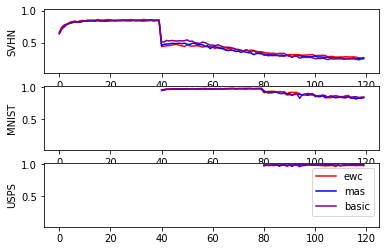

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_result(mode_list, task1, task2, task3):
  
    #draw the lines
    count = 0
    for reg_name in mode_list:
        label = reg_name
        with open(f'./{reg_name}_acc.txt', 'r') as f:
            acc = json.load(f)
        if count == 0: 
            color= 'red'
        elif count  == 1:
            color= 'blue'
        else:
            color = 'purple'
        ax1=plt.subplot(3, 1, 1)
        plt.plot(range(len(acc[task1])),acc[task1],color,label=label)
        ax1.set_ylabel(task1)
        ax2=plt.subplot(3, 1, 2,sharex=ax1,sharey=ax1)
        plt.plot(range(len(acc[task3]),len(acc[task1])),acc[task2],color,label=label)
        ax2.set_ylabel(task2)
        ax3=plt.subplot(3, 1, 3,sharex=ax1,sharey=ax1)
        ax3.set_ylabel(task3)
        plt.plot(range(len(acc[task2]),len(acc[task1])),acc[task3],color,label=label)
        count += 1
    plt.ylim((0.02,1.02))
    plt.legend()
    plt.show()
    return 

mode_list = ['ewc','mas','basic']
plot_result(mode_list,'SVHN','MNIST','USPS')

In [34]:
import pandas as pd

for reg_name in mode_list:
    with open(f'./{reg_name}_acc.txt', 'r') as f:
            acc = json.load(f)
    test_acc = pd.DataFrame(acc['MNIST'])
    
test_acc

,0
0,0.951833
1,0.958167
2,0.968500
3,0.969833
4,0.970333
...,...
75,0.851667
76,0.854667
77,0.841833
78,0.847167


在今年 ICLR 2020 的 paper，有以這兩種方法做 baseline，並對這兩種方法各自做了一個 geometry view，也提出新的方法，有興趣的人可以參考

paper link 如下 [SLICED CRAMER´ SYNAPTIC CONSOLIDATION FOR
PRESERVING DEEPLY LEARNED REPRESENTATIONS](https://openreview.net/pdf?id=BJge3TNKwH)

# 進階 
請實做其他的 regularization 的方法，助教有提供的是 SCP 的作法，

你也可以考慮實做出 SI, Rimennian Walk, IMM, 或是上面的方法, 

你可以參考助教上方的寫法，寫出雷同的 class 跟 training 來 train，

記得畫出與上方雷同的 evaluation 圖表 (show result) example 需要比對的話 可以參考助教給的 slide。


In [ ]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [ ]:
class SCP(object):
    """
    OPEN REVIEW VERSION:
    https://openreview.net/forum?id=BJge3TNKwH
    """
    def __init__(self, model: nn.Module, dataloaders: list, L: int, device):
        self.model = model 
        self.dataloaders = dataloaders
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self.L= L
        self.device = device
        self._precision_matrices = self.calculate_importance()
    
        for n, p in self.params.items():
            self._means[n] = p.clone().detach()
    
    def calculate_importance(self):
        print('Computing SCP')

        precision_matrices = {}
        for n, p in self.params.items():
            precision_matrices[n] = p.clone().detach().fill_(0)

        self.model.eval()
        dataloader_num = len(self.dataloaders)
        num_data = sum([len(loader) for loader in self.dataloaders])
        for dataloader in self.dataloaders:
            for data in dataloader:
                self.model.zero_grad()
                output = self.model(data[0].to(self.device))

                ####################################################################################
                #####                            TODO 區塊 （ PART 2 ）                           #####
                ####################################################################################
                ##### 產生 SCP 的 Gamma(Γ) 矩陣（ 如同 MAS 的 Omega(Ω) 矩陣, EWC 的 Fisher(F) 矩陣 ）#####
                ####################################################################################
                #####        1.對所有資料的 Output vector 取 平均 得到 平均 vector φ(:,θ_A* )       #####
                ####################################################################################

                ####################################################################################
                #####   2. 隨機 從 單位球殼 取樣 L 個 vector ξ #（ Hint: sample_spherical() ）      #####
                ####################################################################################

                ####################################################################################
                #####   3.    每一個 vector ξ 和 vector φ( :,θ_A* )內積得到 scalar ρ               #####
                #####           對 scalar ρ 取 backward ， 每個參數得到各自的 gradient ∇ρ           #####
                #####       每個參數的 gradient ∇ρ 取平方 取 L 平均 得到 各個參數的 Γ scalar          #####  
                #####              所有參數的  Γ scalar 組合而成其實就是 Γ 矩陣                      #####
                ####(hint: 記得 每次 backward 之後 要 zero_grad 去 清 gradient, 不然 gradient會累加 )######   
                ####################################################################################
      
                ####################################################################################      
                #####                            TODO 區塊 （ PART 2 ）                          #####
                ####################################################################################

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

In [ ]:
def scp_train(model, optimizer, task, total_epochs, summary_epochs, scp_tasks, lambda_scp,alpha=0.65):
  losses = []
  loss = 0.0
  ###############################
  #####  TODO 區塊 （PART 2） #####
  ###############################
  ##  參考 MAS. EWC train 的寫法 ##                 
  ###############################
  #####  TODO 區塊 （PART 2） #####
  ###############################
  return model, optimizer, losses

In [ ]:
# if __name__ == "__main__": 
#   pass 
###############################
#####  TODO 區塊 （PART 2） #####
###############################
##     參考 main 區塊一樣       ##                 
##     的 code 結合新方法       ##
###############################
#####  TODO 區塊 （PART 2） #####
###############################

In [ ]:
acc

In [ ]:
acc